# Using MARL for Radio Resource Scheduling in a RAN Slicing Scenario

We are going to utilize a PPO MARL system to schedule radio resources in a mobile network with RAN slicing. The scheduler system is composed of inter- and intra-slice schedulers. The inter-slice scheduler is responsible for allocating resources to slices, while the intra-slice scheduler is responsible for allocating resources to users within a slice.

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import gymnasium.spaces as spaces
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from ray.tune.registry import register_env
import numpy as np
from ray import air, tune
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.algorithm import Algorithm
from typing import Dict
from ray.rllib.policy.policy import PolicySpec

# sixg_radio_mgmt
from sixg_radio_mgmt import (
    MARLCommEnv,
    Association,
    UEs,
    Channel,
    Mobility,
    Traffic,
    Agent,
)
from typing import Optional, Tuple, Union

## Radio resource scheduler simulator

Most of the classes that implement the simulation behavior are the same from previous notebooks such as the one from [lesson 1 nb3](../lesson_1/3-rl_agent_for_radio_resource_scheduler.ipynb). But, for the following `SimpleAssociation` class, we are adding an indication that the first 3 UEs are associated to the slice 0 (eMBB), and the other 2 UEs to the slice 1 (URLLC).

In [2]:
class SimpleAssociation(Association):
    def __init__(
        self,
        ues: UEs,
        max_number_ues: int,
        max_number_basestations: int,
        max_number_slices: int,
        rng: np.random.Generator = np.random.default_rng(),
        root_path: str = "",
        scenario_name: str = "",
    ) -> None:
        super().__init__(
            ues,
            max_number_ues,
            max_number_basestations,
            max_number_slices,
            rng,
            root_path,
            scenario_name,
        )
        self.basestation_ue_assoc = np.ones((1, max_number_ues), dtype=int)
        self.basestation_slice_assoc = np.ones((1, max_number_slices), dtype=int)
        self.slice_ue_assoc = np.zeros((2, max_number_ues), dtype=int)
        self.slice_ue_assoc[0, 0:3] = 1  # First three UEs associated to slice 0 (eMBB)
        self.slice_ue_assoc[1, 3:] = 1  # Other 2 UEs associated to slice 1 (URLLC)

    def step(
        self,
        basestation_ue_assoc: np.ndarray,
        basestation_slice_assoc: np.ndarray,
        slice_ue_assoc: np.ndarray,
        slice_req: Optional[dict],
        step_number: int,
        episode_number: int,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, Optional[dict]]:
        return (
            basestation_ue_assoc,
            basestation_slice_assoc,
            slice_ue_assoc,
            slice_req,
        )

The other simulator classes are exactly the same from the [lesson 1 nb3](../lesson_1/3-rl_agent_for_radio_resource_scheduler.ipynb).

In [3]:
class SimpleChannel(Channel):
    def __init__(
        self,
        max_number_ues: int,
        max_number_basestations: int,
        num_available_rbs: np.ndarray,
        rng: np.random.Generator = np.random.default_rng(),
        root_path: str = "",
        scenario_name: str = "",
    ) -> None:
        super().__init__(
            max_number_ues,
            max_number_basestations,
            num_available_rbs,
            rng,
            root_path,
            scenario_name,
        )
        self.current_episode_number = -1
        self.ues_mean_se = np.array([])
        self.default_std = 1.5

    def step(
        self,
        step_number: int,
        episode_number: int,
        mobilities: np.ndarray,
        sched_decision: Optional[np.ndarray] = None,
    ) -> np.ndarray:
        if episode_number != self.current_episode_number:
            self.current_episode_number = episode_number
            self.ues_mean_se = np.abs(
                self.rng.normal(5, 1, size=(self.max_number_ues,))
            )

        spectral_efficiencies = np.array(
            [
                np.ones((self.max_number_ues, self.num_available_rbs[i]))
                for i in np.arange(self.max_number_basestations)
            ]
        )
        for ue_idx, ue_mean in enumerate(self.ues_mean_se):
            spectral_efficiencies[0, ue_idx, :] = np.abs(
                self.rng.normal(
                    ue_mean,
                    self.default_std,
                    size=(self.num_available_rbs[0],),
                )
            )

        return spectral_efficiencies

In [4]:
class SimpleMobility(Mobility):
    def __init__(
        self,
        max_number_ues: int,
        rng: np.random.Generator = np.random.default_rng(),
        root_path: str = "",
    ) -> None:
        super().__init__(max_number_ues, rng, root_path)

    def step(self, step_number: int, episode_number: int) -> np.ndarray:
        return np.ones((self.max_number_ues, 2))

In [5]:
class SimpleTraffic(Traffic):
    def __init__(
        self,
        max_number_ues: int,
        rng: np.random.Generator = np.random.default_rng(),
        root_path: str = "",
    ) -> None:
        super().__init__(max_number_ues, rng, root_path)
        self.traffics_pattern = {
            "embb": {
                "num_ues": 3,
                "ue_throughput": 100,
            },
            "urllc": {
                "num_ues": 2,
                "ue_throughput": 10,
            },
        }

    def step(
        self,
        slice_ue_assoc: np.ndarray,
        slice_req: dict,
        step_number: int,
        episode_number: int,
    ) -> np.ndarray:
        traffic_per_ue = np.zeros(self.max_number_ues)

        # eMBB
        traffic_per_ue[0 : self.traffics_pattern["embb"]["num_ues"]] = (
            self.rng.poisson(
                self.traffics_pattern["embb"]["ue_throughput"],
                self.traffics_pattern["embb"]["num_ues"],
            )
            * 1e6
        )  # Mbps
        # URLLC
        traffic_per_ue[
            self.traffics_pattern["embb"]["num_ues"] : self.traffics_pattern["embb"][
                "num_ues"
            ]
            + self.traffics_pattern["urllc"]["num_ues"]
        ] = (
            self.rng.poisson(
                self.traffics_pattern["urllc"]["ue_throughput"],
                self.traffics_pattern["urllc"]["num_ues"],
            )
            * 1e6
        )  # Mbps

        return traffic_per_ue

## Defining scenario characteristics

In [ ]:
seed = 10
number_ues = 5
number_basestations = 1
number_slices = 2  # Here, we indicate we are considering 2 slices
rbs_available = np.array([100])

steps_per_episode = 1000
training_episodes = 80
training_epochs = 1
testing_episodes = 20

## RL agent environment connection

Here the definition of the action space, observation space, and reward will be different from the one used in [Lesson 1 notebook 3](../lesson_1/3-rl_agent_for_radio_resource_scheduler.ipynb) since here we are considering a Multi-agent RL. In this scenario with 2 slices, we are going to consider one RL agent to the inter-slice scheduler, and another two RL agents for the intra-slice scheduler in the slice 0 and slice 1 as depicted in the Figure below.

![MARL scheduler](imgs/marl_scheduler.png)

Therefore, the observations, actions, and rewards must contain a dictionary with their values for each RL agent. In the code below, we implement that. The observation space to the inter-slice scheduler contains the buffer occupancies and spectral efficiences for all the UEs in the system, while the first intra-slice scheduler (slice 0) will contain information of only three UEs, while the last intra-slice scheduler will contain information of only the last two UEs.

The action of the inter-slice is defining the number of RBs for each slice. While the intra-slice schedulers define the number of RBs for each UE they contain.

Finally, the reward function will be defined as the total throughput achieved for the eMBB UEs, everytime we achieve URLLC UEs with buffer delay smaller than 1ms. So, the MARL will learn to first keep the latencies of URLLC applications under 1ms, and after that to maximize the throughput of the eMBB UEs.

For simplicity and to obbey to the MARL environment definition, the inter-slice scheduler, eMBB intra-slice scheduler, and URLLC intra-slice scheduler will be represented as player 0, 1 and 2.

In [7]:
class RLSimple(Agent):
    def __init__(
        self,
        env: MARLCommEnv,
        max_number_ues: int,
        max_number_slices: int,
        max_number_basestations: int,
        num_available_rbs: np.ndarray,
        hyperparameters: dict = {},
        seed: int = np.random.randint(1000),
    ) -> None:
        super().__init__(
            env,
            max_number_ues,
            max_number_slices,
            max_number_basestations,
            num_available_rbs,
            seed,
        )
        self.agent_name = "ray_ppo"
        self.current_obs = None

    def step(self, obs_space: Union[np.ndarray, dict]) -> np.ndarray:
        return np.array([])

    def obs_space_format(self, obs_space: dict) -> Union[np.ndarray, dict]:
        # Function that create the observations
        self.current_obs = obs_space
        formatted_obs_space = np.array([])
        hist_labels = [
            "buffer_occupancies",
            "spectral_efficiencies",
        ]
        for hist_label in hist_labels:
            if hist_label == "spectral_efficiencies":
                spectral_eff_ues = (
                    np.mean(obs_space[hist_label][0], axis=1) / 20
                )  # Normalizing by 20
                formatted_obs_space = np.append(
                    formatted_obs_space,
                    spectral_eff_ues,
                    axis=0,
                )
            else:
                formatted_obs_space = np.append(
                    formatted_obs_space, obs_space[hist_label], axis=0
                )

        marl_obs = {
            "player_0": formatted_obs_space,  # Player 0 is the inter-slice scheduler
            "player_1": formatted_obs_space[  # Player 1 is the intra-slice scheduler for eMBB
                [0, 1, 2, 5, 6, 7]
            ],  # Buffer and SE information for first 3 UEs (eMBB)
            "player_2": formatted_obs_space[  # Player 2 is the intra-slice scheduler for URLLC
                [3, 4, 8, 9]
            ],  # Buffer and SE information for the last 2 UEs (URLLC)
        }

        return marl_obs

    def calculate_reward(self, obs_space: dict) -> Union[float, dict]:
        # The inter-slice reward is the total throughput of eMBB UEs when the URLLC UEs have an average latency lower than 1 ms, otherwise it is -1 * the average latency of URLLC UEs
        # The intra-slice reward for eMBB is the total throughput of eMBB UEs and for URLLC, -1 * the average latency of URLLC UEs
        avg_urllc_lat = np.mean(
            obs_space["buffer_latencies"][3:5]
        )  # Avg buffer of last 2 UEs (URLLC)
        total_norm_throughput_embb = (
            np.sum(obs_space["pkt_effective_thr"][0:3], dtype=float) * 65536 / 1e6
        ) / 1000  # Achieved throughput in Mbps divided by 1000 for normalization
        inter_slice_reward = (
            total_norm_throughput_embb if avg_urllc_lat < 1 else -avg_urllc_lat
        )
        reward = {
            "player_0": inter_slice_reward,
            "player_1": total_norm_throughput_embb,
            "player_2": -avg_urllc_lat,
        }

        return reward

    def action_format(
        self,
        action: Union[np.ndarray, dict],
    ) -> np.ndarray:
        # Function that generate the actions
        inter_slice_action = deepcopy(action["player_0"])
        intra_embb_action = deepcopy(action["player_1"])
        intra_urllc_action = deepcopy(action["player_2"])

        sched_decision = np.array(
            [
                np.zeros((self.max_number_ues, self.num_available_rbs[basestation]))
                for basestation in np.arange(self.max_number_basestations)
            ]
        )

        # In case all outputs are 0, fill the values with one to avoid division by zero
        if np.sum(inter_slice_action + 1) == 0:
            inter_slice_action = np.ones_like(inter_slice_action)
        if np.sum(intra_urllc_action + 1) == 0:
            intra_urllc_action = np.ones_like(intra_urllc_action)
        if np.sum(intra_embb_action + 1) == 0:
            intra_embb_action = np.ones_like(intra_embb_action)

        # Inter-slice action
        rbs_per_slice = np.floor(
            self.num_available_rbs[0]
            * (inter_slice_action + 1)
            / np.sum(inter_slice_action + 1)
        )
        slice_idx = 0
        while (
            np.sum(rbs_per_slice) != self.num_available_rbs[0]
        ):  # Distribute remaining RBs for slices
            rbs_per_slice[slice_idx] += 1
            slice_idx += 1
            if slice_idx == self.max_number_slices:
                slice_idx = 0

        rbs_per_ue = np.zeros(self.max_number_ues)
        # Intra-slice action for eMBB
        rbs_per_ue_embb = np.floor(
            rbs_per_slice[0] * (intra_embb_action + 1) / np.sum(intra_embb_action + 1)
        )
        assert not np.isnan(rbs_per_ue_embb).any(), "NaN values in action"
        ue_embb_idx = 0
        while np.sum(rbs_per_ue_embb) != rbs_per_slice[0]:
            rbs_per_ue_embb[ue_embb_idx] += 1
            ue_embb_idx += 1
            if ue_embb_idx == 3:
                ue_embb_idx = 0

        # Intra-slice action for URLLC
        rbs_per_ue_urllc = np.floor(
            rbs_per_slice[1] * (intra_urllc_action + 1) / np.sum(intra_urllc_action + 1)
        )
        assert not np.isnan(rbs_per_ue_urllc).any(), "NaN values in action"
        ue_urllc_idx = 0
        while np.sum(rbs_per_ue_urllc) != rbs_per_slice[1]:
            rbs_per_ue_urllc[ue_urllc_idx] += 1
            ue_urllc_idx += 1
            if ue_urllc_idx == 2:
                ue_urllc_idx = 0

        # Scheduling defined RBs for UEs
        rbs_per_ue[0:3] = rbs_per_ue_embb
        rbs_per_ue[3:] = rbs_per_ue_urllc
        sched_decision = self.distribute_rbs_ues(
            rbs_per_ue,
            sched_decision,
            np.arange(self.max_number_ues),
            self.num_available_rbs,
            0,
        )

        assert (
            np.sum(sched_decision) == self.num_available_rbs[0]
        ), "Allocated RBs are different from available RBs"

        return sched_decision

    def get_action_space(
        self,
    ) -> (
        spaces.Dict
    ):  # The observation now is a dict with the observations for each RL agent
        action_space = spaces.Dict(
            {
                "player_0": spaces.Box(  # The inter-slice has one output per slice
                    low=-1, high=1, shape=(self.max_number_slices,), dtype=np.float64
                ),
                "player_1": spaces.Box(  # The intra-slice has one output per eMBB UE
                    low=-1, high=1, shape=(3,), dtype=np.float64
                ),
                "player_2": spaces.Box(  # The intra-slice has one output per URLLC UE
                    low=-1, high=1, shape=(2,), dtype=np.float64
                ),
            }
        )

        return action_space

    def get_obs_space(
        self,
    ) -> spaces.Dict:
        obs_space = spaces.Dict(
            {
                "player_0": spaces.Box(  # The inter-slice receives info from all UEs
                    low=0,
                    high=np.inf,
                    shape=(2 * self.max_number_ues,),
                    dtype=np.float64,
                ),
                "player_1": spaces.Box(  # The intra-slice receives info from all eMBB UEs
                    low=0,
                    high=np.inf,
                    shape=(2 * 3,),
                    dtype=np.float64,
                ),
                "player_2": spaces.Box(  # The intra-slice receives info from all URLLC UEs
                    low=0,
                    high=np.inf,
                    shape=(2 * 2,),
                    dtype=np.float64,
                ),
            }
        )
        return obs_space

    def distribute_rbs_ues(
        self,
        rbs_per_ue: np.ndarray,
        allocation_rbs: np.ndarray,
        slice_ues: np.ndarray,
        rbs_per_slice: np.ndarray,
        slice_idx: int,
    ) -> np.ndarray:
        rb_idx = np.sum(rbs_per_slice[:slice_idx], dtype=int)
        for idx, ue_idx in enumerate(slice_ues):
            allocation_rbs[0, ue_idx, rb_idx : rb_idx + rbs_per_ue[idx].astype(int)] = 1
            rb_idx += rbs_per_ue[idx].astype(int)

        return allocation_rbs

When using a custom environment in Ray RLlib, a function that returns the environment needs to be created to register the environment using Ray API:

In [8]:
def env_creator(env_config, training=True):
    comm_env = MARLCommEnv(  # Here we are using a MARL environment instead of a single agent environment
        ChannelClass=SimpleChannel,
        TrafficClass=SimpleTraffic,
        MobilityClass=SimpleMobility,
        AssociationClass=SimpleAssociation,
        config_file="rrs_simple",
        simu_name="rrs_simple",
        agent_name="ray_ppo",
    )
    rl_api = RLSimple(
        comm_env,
        number_ues,
        number_slices,
        number_basestations,
        rbs_available,
    )
    comm_env.set_agent_functions(
        obs_space_format=rl_api.obs_space_format,
        action_format=rl_api.action_format,
        calculate_reward=rl_api.calculate_reward,
        obs_space=rl_api.get_obs_space(),
        action_space=rl_api.get_action_space(),
    )
    comm_env.comm_env.max_number_episodes = 80 if training else 100

    return comm_env


register_env("comm_env", lambda config: env_creator(config))

## Training the MARL agent

Similarly to [Lesson 3 notebook 2](./2-ray_rllib_with_multi_agent_rl.ipynb), here we define a MARL using PPO for 3 different RL agents using Ray RLlib API. First we need to create the tree different policies for each agent and map them to the correct agent.

In [9]:
def generate_policies() -> Dict[str, PolicySpec]:
    policies = {
        "inter_slice_sched": PolicySpec(),
        "intra_slice_embb": PolicySpec(),
        "intra_slice_urllc": PolicySpec(),
    }

    return policies

In [10]:
def policy_mapping_fn(agent_id, episode=None, worker=None, **kwargs):
    agent_idx = int(agent_id.partition("_")[2])
    if agent_idx == 0:
        return "inter_slice_sched"
    elif agent_idx == 1:
        return "intra_slice_embb"
    elif agent_idx == 2:
        return "intra_slice_urllc"
    else:
        raise ValueError("Invalid agent_id: {}".format(agent_id))

In [11]:
config = (
    PPOConfig()
    .environment("comm_env")
    .multi_agent(
        policies=generate_policies(),
        policy_mapping_fn=policy_mapping_fn,
        count_steps_by="env_steps",
    )
    .env_runners(num_env_runners=1)
    .learners(num_learners=1)
    .training(
        lr=0.0003,
        train_batch_size=2048,
        sgd_minibatch_size=64,
        num_sgd_iter=10,
        gamma=0.99,
        lambda_=0.95,
        model={
            "fcnet_hiddens": [64, 64],
            "fcnet_activation": "relu",
        },
        clip_param=0.2,
        entropy_coeff=0.01,
        vf_loss_coeff=0.5,
        grad_clip=0.5,
        vf_clip_param=np.inf,
        use_gae=True,
        kl_coeff=0,
        use_kl_loss=False,
        kl_target=0,
    )
)
stop = {
    "num_env_steps_sampled": 1000 * training_episodes * training_epochs,
}
checkpoint_frequency = 0
store_results_path = str(Path("./ray_results/").resolve()) + "/nb_3/"
agent_name = "ray_ppo"

tuner = tune.Tuner(
    "PPO",
    param_space=config.to_dict(),
    run_config=air.RunConfig(
        storage_path=store_results_path,
        name=agent_name,
        stop=stop,
        verbose=2,
        checkpoint_config=air.CheckpointConfig(
            checkpoint_frequency=checkpoint_frequency,
            checkpoint_at_end=True,
        ),
    ),
)
results = tuner.fit()
print(results)

2024-12-08 18:13:55,495	INFO worker.py:1783 -- Started a local Ray instance.
2024-12-08 18:13:56,007	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2024-12-08 18:13:56,009	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, act

(PPO pid=732147) Install gputil for GPU system monitoring.
(PPO pid=732147) 2024-12-08 18:14:10,532	WARNING deprecation.py:50 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!


Trial name,agent_timesteps_total,counters,custom_metrics,env_runners,episode_media,info,num_agent_steps_sampled,num_agent_steps_sampled_lifetime,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_lifetime,num_env_steps_sampled_this_iter,num_env_steps_sampled_throughput_per_sec,num_env_steps_trained,num_env_steps_trained_this_iter,num_env_steps_trained_throughput_per_sec,num_healthy_workers,num_in_flight_async_sample_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,timers
PPO_comm_env_30329_00000,30720,"{'num_env_steps_sampled': 10240, 'num_env_steps_trained': 10240, 'num_agent_steps_sampled': 30720, 'num_agent_steps_trained': 30720}",{},"{'episode_reward_max': 527.6881448343357, 'episode_reward_min': 428.0986026691118, 'episode_reward_mean': 482.3149314992699, 'episode_len_mean': 1000.0, 'episode_media': {}, 'episodes_timesteps_total': 10000, 'policy_reward_min': {'inter_slice_sched': 235.94524425947012, 'intra_slice_embb': 242.3642521599999, 'intra_slice_urllc': -60.783883682773705}, 'policy_reward_max': {'inter_slice_sched': 289.99331868105367, 'intra_slice_embb': 294.9590548480002, 'intra_slice_urllc': -38.8078046602863}, 'policy_reward_mean': {'inter_slice_sched': 262.4438407197846, 'intra_slice_embb': 267.4215878655999, 'intra_slice_urllc': -47.55049708611481}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [447.5371758539702, 429.2500846334127, 527.6881448343357, 511.01202737790726, 456.3027031657762, 428.0986026691118, 524.8960875507389, 516.5439971957114, 490.02156395188223, 491.7989277598522], 'episode_lengths': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'policy_inter_slice_sched_reward': [246.74015641599965, 235.94524425947012, 289.99331868105367, 278.3083514028359, 246.2071006679322, 241.68895188788517, 283.7564446859007, 277.67590092800003, 263.21591443820535, 260.90702383056237], 'policy_intra_slice_embb_reward': [246.74015641599965, 242.3642521599999, 294.9590548480002, 279.6811059200004, 249.23334246399997, 247.1935344639999, 290.7001323519998, 277.67590092800003, 269.1517644800003, 276.516634624], 'policy_intra_slice_urllc_reward': [-45.9431369780312, -49.05941178605891, -57.26422869471655, -46.97742994492887, -39.1377399661561, -60.783883682773705, -49.5604894871617, -38.8078046602863, -42.34611496632361, -45.62473069471116]}, 'sampler_perf': {'mean_raw_obs_processing_ms': 0.4471480007716261, 'mean_inference_ms': 1.637681351448801, 'mean_action_processing_ms': 0.2737580590269866, 'mean_env_wait_ms': 0.90085165338969, 'mean_env_render_ms': 0.0}, 'num_faulty_episodes': 0, 'connector_metrics': {'ObsPreprocessorConnector_ms': 0.004923343658447266, 'StateBufferConnector_ms': 0.0025685628255208335, 'ViewRequirementAgentConnector_ms': 0.059893131256103516}, 'num_episodes': 2, 'episode_return_max': 527.6881448343357, 'episode_return_min': 428.0986026691118, 'episode_return_mean': 482.3149314992699, 'episodes_this_iter': 2}",{},"{'learner': {'inter_slice_sched': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 0.4999582880176604, 'cur_kl_coeff': 0.0, 'cur_lr': 0.0003, 'total_loss': 1.1905494574806652, 'policy_loss': -0.0025439665449084716, 'vf_loss': 2.4400213992223145, 'vf_explained_var': 0.08803106546401977, 'kl': 0.0, 'entropy': 2.691726929694414, 'entropy_coeff': 0.009999999999999998}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 64.0, 'num_grad_updates_lifetime': 1440.5, 'diff_num_grad_updates_vs_sampler_policy': 159.5}, 'intra_slice_urllc': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 0.4894226896110922, 'cur_kl_coeff': 0.0, 'cur_lr': 0.0003, 'total_loss': 0.3435423627903219, 'policy_loss': -0.0030240072694141416, 'vf_loss': 0.7451427254360169, 'vf_explained_var': -0.009789981506764888, 'kl': 0.0, 'entropy': 2.600499314069748, 'entropy_coeff': 0.009999999999999998}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 64.0, 'num_grad_updates_lifetime': 1440.5, 'diff_num_grad_updates_vs_sampler_policy': 15

2024-12-08 18:14:50,440	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/lasse/ray_minicourse/lesson_3/ray_results/nb_3/ray_ppo' in 0.0126s.
(PPO pid=732147) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/lasse/ray_minicourse/lesson_3/ray_results/nb_3/ray_ppo/PPO_comm_env_30329_00000_0_2024-12-08_18-13-56/checkpoint_000000)
2024-12-08 18:14:50,871	INFO tune.py:1041 -- Total run time: 54.86 seconds (54.38 seconds for the tuning loop).


ResultGrid<[
  Result(
    metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'inter_slice_sched': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 0.4999582880176604, 'cur_kl_coeff': 0.0, 'cur_lr': 0.0003, 'total_loss': 1.1905494574806652, 'policy_loss': -0.0025439665449084716, 'vf_loss': 2.4400213992223145, 'vf_explained_var': 0.08803106546401977, 'kl': 0.0, 'entropy': 2.691726929694414, 'entropy_coeff': 0.009999999999999998}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 64.0, 'num_grad_updates_lifetime': 1440.5, 'diff_num_grad_updates_vs_sampler_policy': 159.5}, 'intra_slice_urllc': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 0.4894226896110922, 'cur_kl_coeff': 0.0, 'cur_lr': 0.0003, 'total_loss': 0.3435423627903219, 'policy_loss': -0.0030240072694141416, 'vf_loss': 0.7451427254360169, 'vf_explained_var': -0.009789981506764888, 'kl': 0.0, 'entropy': 2.600499314069748, 'entropy_coeff': 0.009999999999999998}, 'model': {},

After training the agents, let's read them from model files to use them for testing in the environment.

In [12]:
analysis = tune.ExperimentAnalysis(f"{store_results_path}/{agent_name}/")
assert analysis.trials is not None, "Analysis trial is None"
checkpoint = analysis.get_best_checkpoint(
    trial=analysis.trials[0], metric="env_runners/episode_reward_mean", mode="max"
)
tuner_agent = Algorithm.from_checkpoint(checkpoint)

2024-12-08 18:17:01,956	WARNING deprecation.py:50 -- DeprecationWarning: `_enable_new_api_stack` has been deprecated. Use `AlgorithmConfig._enable_new_api_stack` instead. This will raise an error in the future!
/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:557: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tun

In [ ]:
Similarly

In [ ]:
comm_env = env_creator({}, training=False)
obs, _ = comm_env.reset(
    seed=seed, options={"initial_episode": 80}
)  # Initial observation
for episode in tqdm(range(testing_episodes * 1000)):
    action = {}
    assert isinstance(obs, dict), "Observations must be a dictionary."
    for (
        agent_id,
        agent_obs,
    ) in (
        obs.items()
    ):  # We iterate over the different agents to generate our action dictionary
        policy_id = policy_mapping_fn(agent_id)
        action[agent_id] = tuner_agent.compute_single_action(
            agent_obs,
            policy_id=policy_id,
            explore=True,
        )
    obs, reward, terminated, truncated, info = comm_env.step(
        action
    )  # Applying the action in the environment
    assert isinstance(terminated, dict), "Terminated must be a dictionary."
    if terminated["__all__"]:
        comm_env.reset()

100%|██████████| 10000/10000 [00:28<00:00, 356.43it/s]


/tmp/ipykernel_731013/2370040098.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


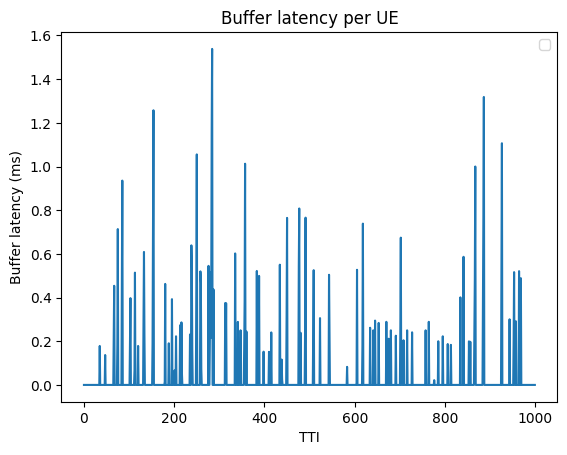

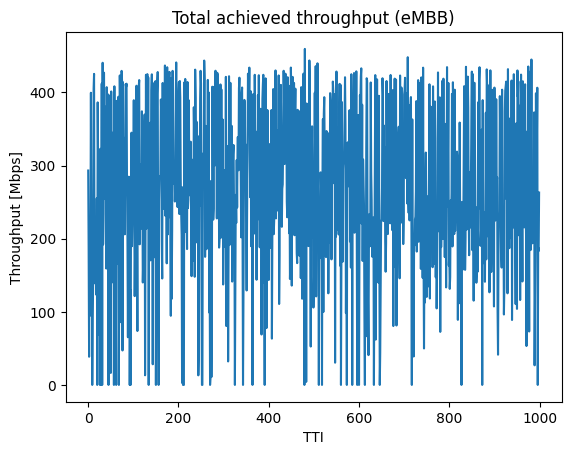

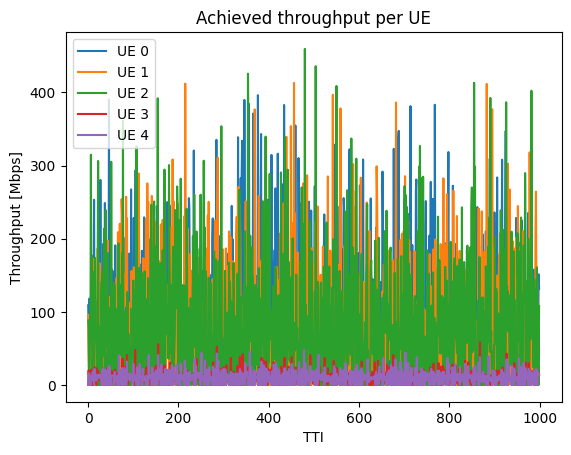

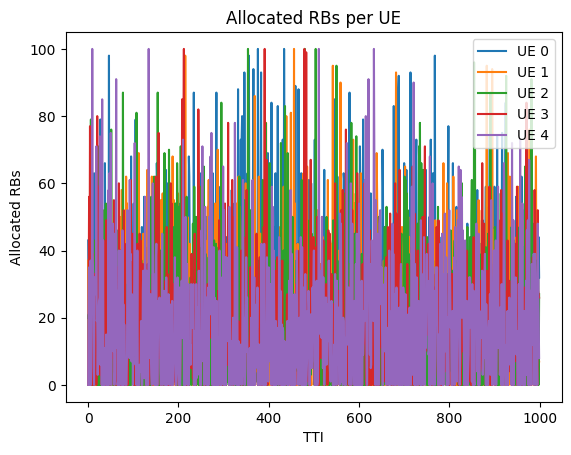

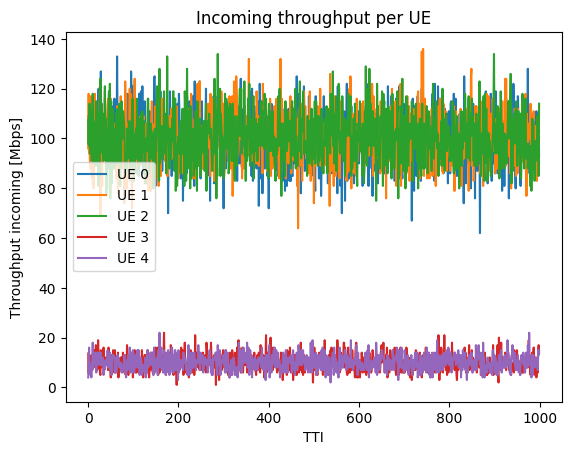

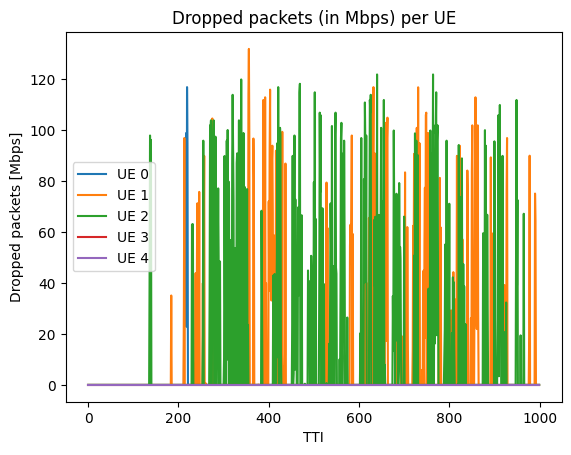

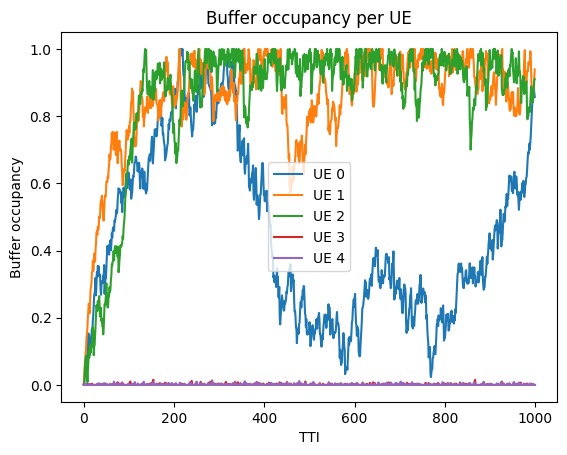

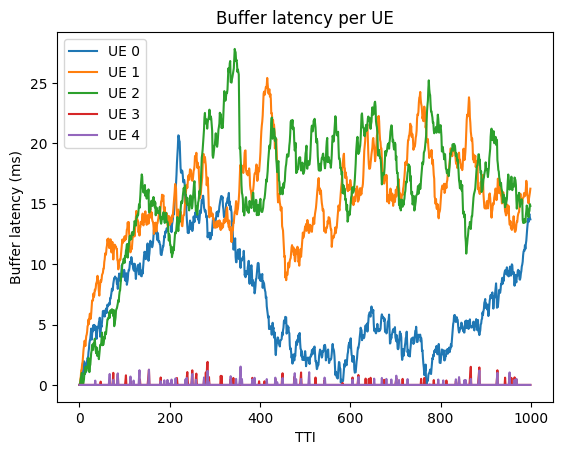

In [ ]:
hist_ep_80 = np.load("hist/rrs_simple/ray_ppo/ep_80.npz")
pkt_size = 65536  # Default packet size in bits
effective_throughput = hist_ep_80["pkt_effective_thr"] * pkt_size / 1e6
pkt_incoming = hist_ep_80["pkt_incoming"] * pkt_size / 1e6
dropped_pkts = hist_ep_80["dropped_pkts"] * pkt_size / 1e6
buffer_occupancies = hist_ep_80["buffer_occupancies"]
total_throughput = np.sum(effective_throughput[:, 0:3], axis=1)  # Only for eMBB UEs
rbs_per_ue = np.squeeze(hist_ep_80["sched_decision"]).sum(axis=2)

# Avg Buffer latencies for URLLC UEs
plt.figure()
plt.plot(
    np.mean(hist_ep_80["buffer_latencies"][:, [3, 4]], axis=1)
)  # Consider the avg only of the URLLC UEs
plt.xlabel("TTI")
plt.ylabel("Buffer latency (ms)")
plt.title("Avg buffer latency for URLLC UEs")
plt.legend()
plt.show()


# Total achieved throughput
plt.figure()
plt.plot(total_throughput, label="Total throughput")
plt.xlabel("TTI")
plt.ylabel("Throughput [Mbps]")
plt.title("Total achieved throughput (eMBB)")
plt.show()

# Achieved throughput per UE
plt.figure()
for ue_idx in np.arange(number_ues):
    plt.plot(effective_throughput[:, ue_idx], label=f"UE {ue_idx}")
plt.xlabel("TTI")
plt.ylabel("Throughput [Mbps]")
plt.legend()
plt.title("Achieved throughput per UE")
plt.show()

# RBs per UE
plt.figure()
for ue_idx in np.arange(number_ues):
    plt.plot(rbs_per_ue[:, ue_idx], label=f"UE {ue_idx}")
plt.xlabel("TTI")
plt.ylabel("Allocated RBs")
plt.legend()
plt.title("Allocated RBs per UE")
plt.show()

# Pkt incoming
plt.figure()
for ue_idx in np.arange(number_ues):
    plt.plot(pkt_incoming[:, ue_idx], label=f"UE {ue_idx}")
plt.xlabel("TTI")
plt.ylabel("Throughput incoming [Mbps]")
plt.legend()
plt.title("Incoming throughput per UE")
plt.show()

# Dropped packets
plt.figure()
for ue_idx in np.arange(number_ues):
    plt.plot(dropped_pkts[:, ue_idx], label=f"UE {ue_idx}")
plt.xlabel("TTI")
plt.ylabel("Dropped packets [Mbps]")
plt.legend()
plt.title("Dropped packets (in Mbps) per UE")
plt.show()

# Buffer occupancies
plt.figure()
for ue_idx in np.arange(number_ues):
    plt.plot(buffer_occupancies[:, ue_idx], label=f"UE {ue_idx}")
plt.xlabel("TTI")
plt.ylabel("Buffer occupancy")
plt.legend()
plt.title("Buffer occupancy per UE")
plt.show()

# Buffer latencies
plt.figure()
for ue_idx in np.arange(number_ues):
    plt.plot(hist_ep_80["buffer_latencies"][:, ue_idx], label=f"UE {ue_idx}")
plt.xlabel("TTI")
plt.ylabel("Buffer latency (ms)")
plt.title("Buffer latency per UE")
plt.legend()
plt.show()